# Kepler | Star classification
*Anaelle JAFFRÉ, Guénaël ROGER*

This Jupyter Notebook is a report refering to an experimental project. It aims to discover an application of Echo State Networks (ESN) throughout a dataset of Kepler labelled time series data.

## Objective

The final objective of this project is to classify the stars of the dataset, depending on if they do have an exoplanet in their system of not.

Additionally, a transit prediction can be added as a second objective.

## Global methodology

We have time series representing measurements of the brightness of stars over time. The ESN studies slow variations, flux drops, noise and recurring patterns in order to determine whether or not there is a transit (presence of an exoplanet). If this works, the ESN will be adapted to enable transit prediction (bonus).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

from sklearn.metrics import accuracy_score, roc_auc_score


## Dataset

We are using the [Exoplanet Hunting in Deep Space](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data?resource=download) which contains information about "the change in flux (light sensitivity) of several thousand stars". Each star is labelized according to the presence or not of exoplanet.

In [2]:
DATA_PATH = Path("../data")

train_df = pd.read_csv(DATA_PATH / "exoTrain.csv")
test_df  = pd.read_csv(DATA_PATH / "exoTest.csv")

The training dataset is composed of 5087 entries, in which 37 are stars with exoplanets.

The testing dataset is composed of 570 entries, in which 5 are stars with exoplanets.

Having such a difference between the two classes can cause some issues. Such impact will be discussed in the conclusion.

In [3]:
train_df.shape, test_df.shape # type: ignore

print(train_df["LABEL"].value_counts())
print(test_df["LABEL"].value_counts())

LABEL
1    5050
2      37
Name: count, dtype: int64
LABEL
1    565
2      5
Name: count, dtype: int64


In the dataset, a label of "1" means the star does not have an expoplanet, while a label of "2" means the star has at least one exoplanet.

For clearer comprehension, we will substract 1 to these values, so that "**0**" means **no exoplanet** and "**1**" means the **existence of an exoplanet**.

### Séparation X/y

Par convention, en colonne 0 on a les labels, et le reste c'est les séries temporelles.

In [4]:
y_train = train_df.iloc[:, 0].values
X_train = train_df.iloc[:, 1:].values

y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values


Stats globales

In [5]:
X_train.mean(), X_train.std()

(np.float64(130.41674038757165), np.float64(22072.212527378146))

##### Visualization

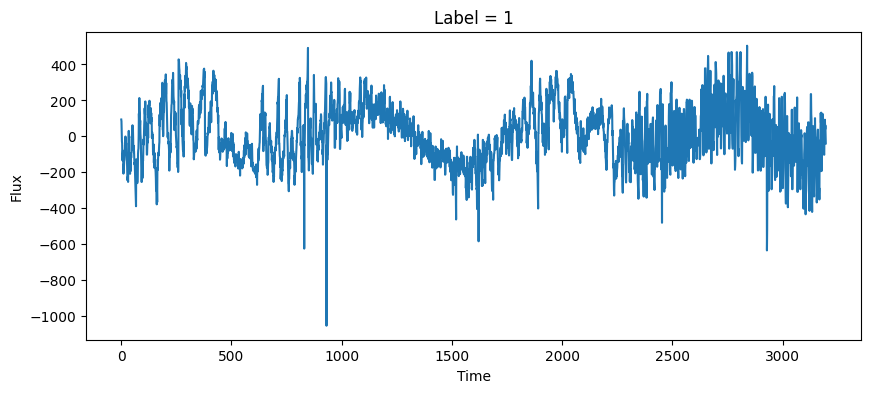

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(X_train[0])
plt.title(f"Label = {int(y_train[0]-1)}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

#### Mise en forme pour l'ESN

##### Bases

In [7]:
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# Sequences
X_train_seq = [x for x in X_train]
X_test_seq  = [x for x in X_test]

# Verify the shape of X: must be (n, 1)
print(X_train_seq[0].shape)

# Reshape y
y_train_seq = [
    np.full((x.shape[0], 1), y)
    for x, y in zip(X_train_seq, y_train)
]

y_test_seq = [
    np.full((x.shape[0], 1), y)
    for x, y in zip(X_test_seq, y_test)
]

# Verify the shape of y: must be (n, 1)
print(y_train_seq[0].shape)

# Float labels
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Normalisation
mean = np.mean(X_train)
std  = np.std(X_train)

X_train_seq = [(x - mean) / std for x in X_train_seq]
X_test_seq  = [(x - mean) / std for x in X_test_seq]

(3197, 1)
(3197, 1)


##### Parameters

In [8]:
units = 20
leak_rate = 0.4
input_scaling = 0.5
spectral_radius = 0.9
ridge = 1e-6

### ESN

In [9]:
reservoir = Reservoir(
    units=units,
    lr=leak_rate,
    input_scaling=input_scaling,
    sr=spectral_radius
)

readout = Ridge(ridge=ridge)

esn = reservoir >> readout

### Training and Evaluation

In [10]:
# Convert labels in numpy objects
y_train_seq_np = [np.array(y) for y in y_train_seq]
y_test_np = np.array(y_test).astype(int)

# Convert labels 1/2 to 0/1, for "non-exoplanet/exoplanet"
y_train_np = np.array(y_train).astype(int) - 1
y_test_np  = np.array(y_test).astype(int) - 1

# Training
esn.fit(X_train_seq, y_train_seq_np)

# Prediction
y_pred_seq = esn.run(X_test_seq)  # one sequence per entry
y_pred = np.array([yp.mean() for yp in y_pred_seq])  # moyenne pour une décision par série
y_pred_label = (y_pred > 0.5).astype(int)

# Evaluation
accuracy = accuracy_score(y_test_np, y_pred_label)
auc = roc_auc_score(y_test_np, y_pred)

accuracy, auc


(0.008771929824561403, 0.6693805309734514)

### First tests

#### Base parameters
```
units = 20
leak_rate = 0.3
input_scaling = 0.5
spectral_radius = 0.9
ridge = 1e-6
```

#### Leak Rate

##### ``Lr = 0.3``

1. Accuracy = 99%. Mostly all of the test series were classified correctly, but this can be misleading if classes are imbalanced.
2. AUC = 67%: the model separates classes better than chance, but struggles with the minority class (exoplanets).
   
##### ``Lr = 0.4``
1. Accuracy = 
2. AUC = 
3. Number of errors: 


##### ``Lr = 0.2``
1. Accuracy = 
2. AUC =
3. Number of errors: 

### Results Visualization

#### Errors

We can print the real label of the first 10 errors, to see what kind of errors does the ESN make.

Number of errors: 565 on 570


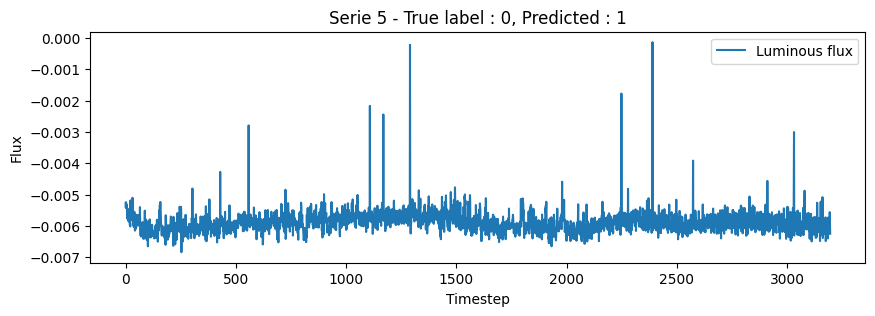

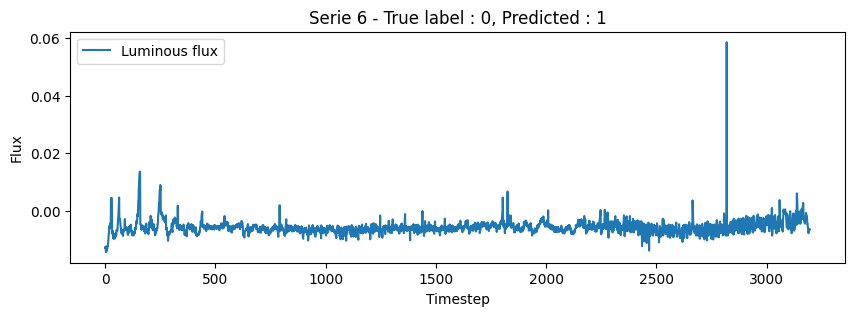

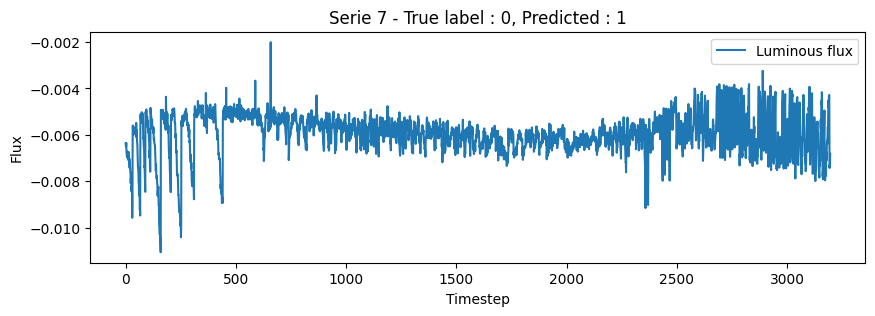

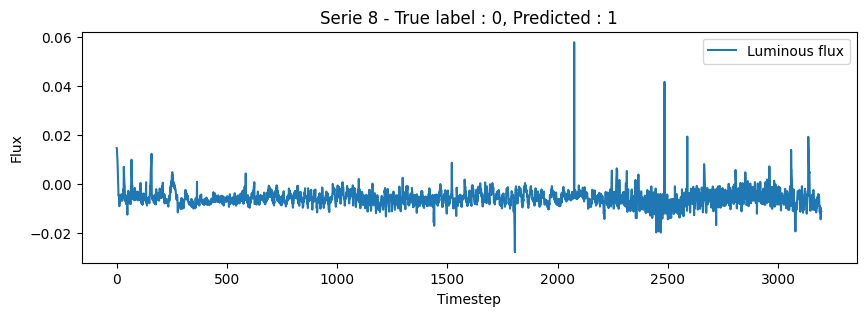

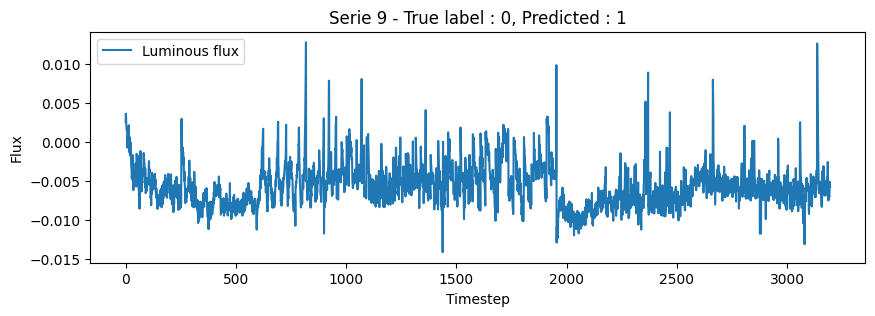

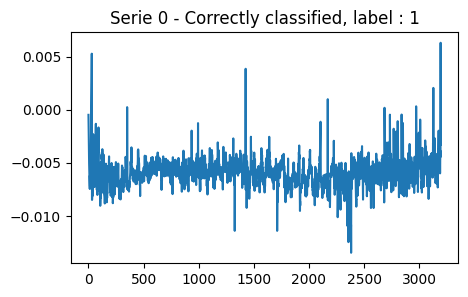

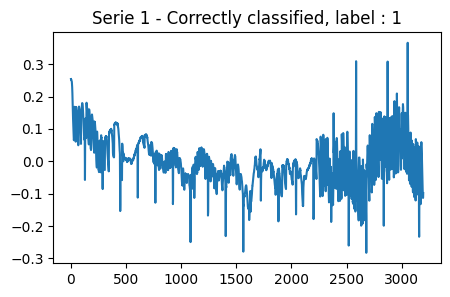

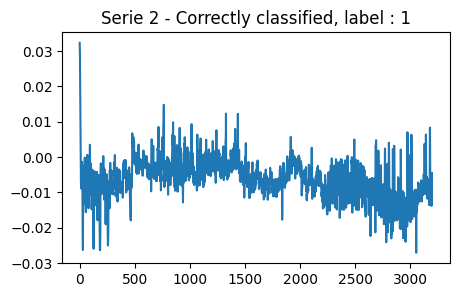

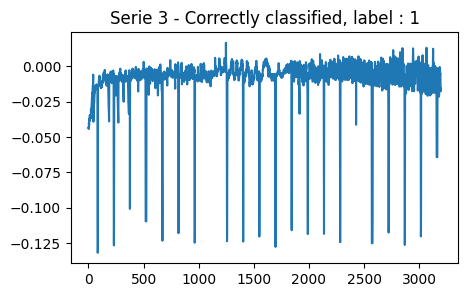

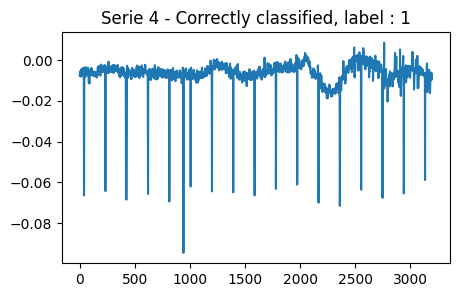

In [11]:
# Errors indices
errors = np.where(y_test_np != y_pred_label)[0]
print(f"Number of errors: {len(errors)} on {len(y_test_np)}")

# Print the 5 first errors
for i in errors[:5]:
    plt.figure(figsize=(10, 3))
    plt.plot(X_test_seq[i].squeeze(), label="Luminous flux")
    plt.title(f"Serie {i} - True label : {y_test_np[i]}, Predicted : {y_pred_label[i]}")
    plt.xlabel("Timestep")
    plt.ylabel("Flux")
    plt.legend()
    plt.show()

# Print the correct labels
correct = np.where(y_test_np == y_pred_label)[0]

for i in correct[:5]:
    plt.figure(figsize=(5, 3))
    plt.plot(X_test_seq[i].squeeze(), label="Luminous flux")
    plt.title(f"Serie {i} - Correctly classified, label : {y_test_np[i]}")
    plt.show()


## Conclusion

[TODO] parler l'impact de la répartition déséqiulibrée des données